In [1]:
import copy
import os
from os import walk
import time
import shutil 
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Loaded all libraries")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loaded all libraries


In [2]:
fpath = "/kaggle/input/knee-osteoarthritis-dataset-with-severity"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:20]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['auto_test', 'val', 'test', 'train'] 

No. of categories =  4


In [3]:
train_dir = os.path.join(fpath,'train')
val_dir = os.path.join(fpath,'val')
test_dir = os.path.join(fpath, 'test')

In [4]:
train_categories = sorted(os.listdir(train_dir))
print("List of train categories = ",categories,"\n\nNo. of train categories = ", len(categories))

List of train categories =  ['auto_test', 'val', 'test', 'train'] 

No. of train categories =  4


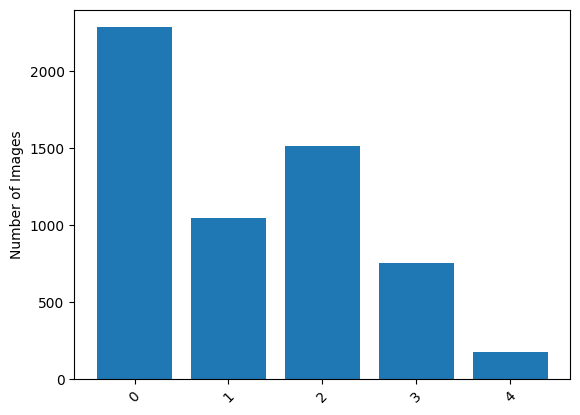

In [5]:
import matplotlib.pyplot as plt

subdirectories = sorted([os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
#plotting bar chart.
x1 = [0,1,2,3,4]
xticks =['0','1','2','3','4']
plt.xticks(x1, xticks, rotation=45)
plt.ylabel("Number of Images")
plt.show()

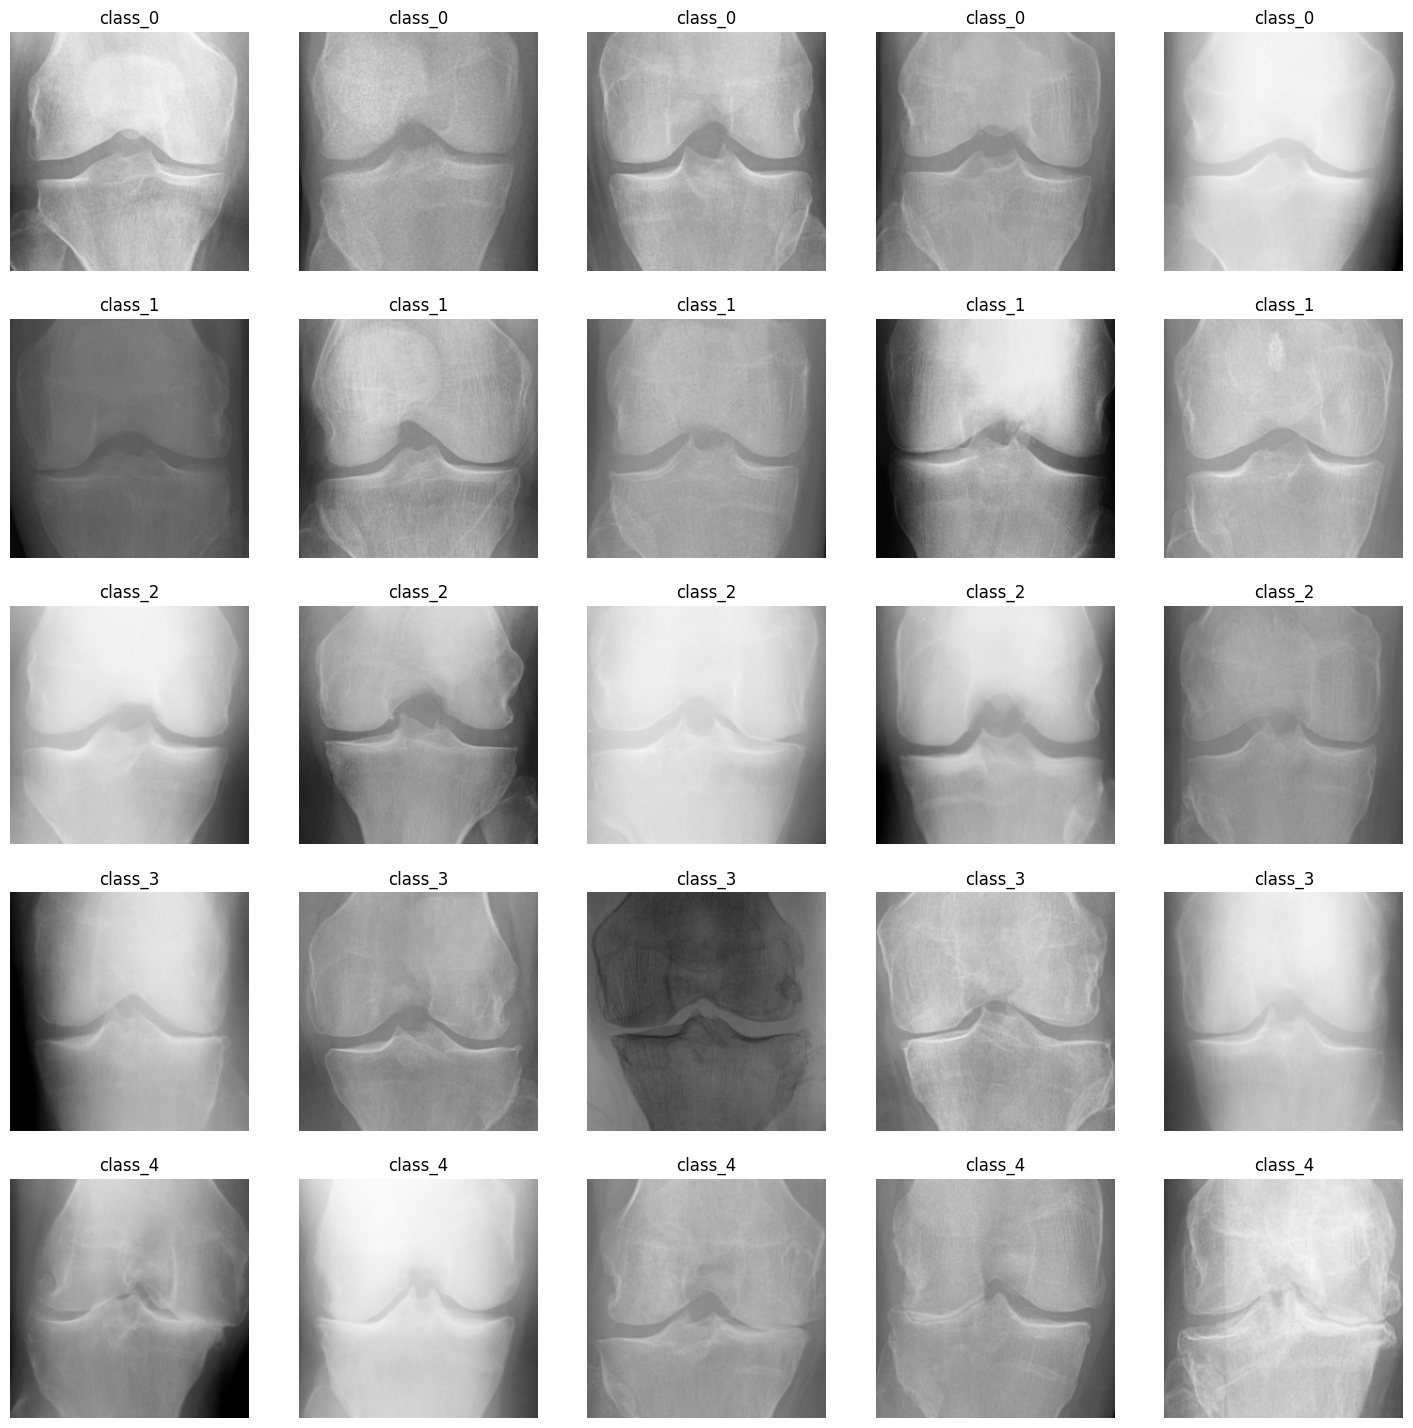

In [6]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for class_id in range(5):
    folder = os.path.join(train_dir,str(class_id))
    os.chdir(folder)
    samples = random.sample(os.listdir(folder), 5)
    
    for col in range(5):
        image = cv2.imread(samples[col])
        ax[class_id, col].imshow(image)
        ax[class_id, col].set_title("class_" + str(class_id))
        ax[class_id, col].set_axis_off()
    
plt.show()

# copy train data to deal with it

In [7]:
# Set paths for the Kaggle input and temporary output folders
input_folder = train_dir
temp_output_folder = '/kaggle/working/temp'

# Make sure the temporary output folder exists
os.makedirs(temp_output_folder, exist_ok=True)

# List the files and subdirectories in the Kaggle input folder
files_and_subfolders = os.listdir(input_folder)

# Copy each file/subfolder from the input to the temp output folder
for item in files_and_subfolders:
    source_path = os.path.join(input_folder, item)
    destination_path = os.path.join(temp_output_folder, item)
    
    # Use shutil.copy or shutil.copytree for files or folders, respectively
    if os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path)
    else:
        shutil.copy(source_path, destination_path)

print(f"Training data copied from {input_folder} to {temp_output_folder}.")


Training data copied from /kaggle/input/knee-osteoarthritis-dataset-with-severity/train to /kaggle/working/temp.


# function to undersampeling of class 0

In [8]:
import os
import random

def delete_remaining_images( num_images_to_keep):
    class_folder = os.path.join(temp_output_folder, '0')
    # Get a list of all files in the class folder
    all_files = os.listdir(class_folder)
    # Select a random subset of files to keep
    files_to_keep = random.sample(all_files, num_images_to_keep)

    # Delete remaining files in the class folder
    for filename in all_files:
        file_path = os.path.join(class_folder, filename)
        # Delete the file if it's not in the selected subset
        if filename not in files_to_keep:
            os.remove(file_path)

# Delete remaining images in the same class
delete_remaining_images(1500)


In [9]:
len(os.listdir(os.path.join(temp_output_folder, '0')))

1500

# distribution for updated data

In [10]:
def show_distribution(folder):
    
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(folder)

    counter = Counter(generator.classes)                          
    total_images = sum(counter.values())
    distribution = [(class_id,round(num_images / total_images * 100,2)) for class_id, num_images in counter.items()]

    for class_id, percentage in distribution:
        print(class_id, percentage)

In [11]:
print("The distribution for the training data is :\n")
show_distribution(temp_output_folder)

The distribution for the training data is :

Found 4992 images belonging to 5 classes.
0 30.05
1 20.95
2 30.37
3 15.16
4 3.47


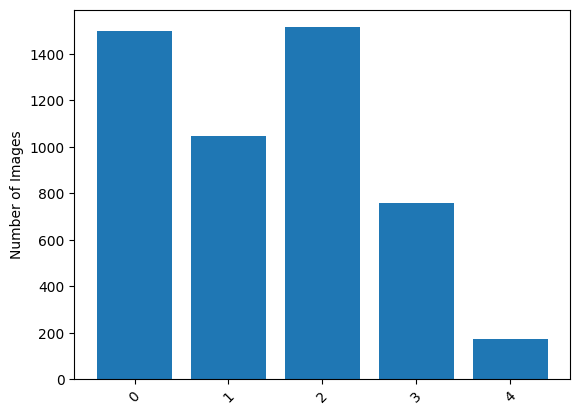

In [12]:
import matplotlib.pyplot as plt

subdirectories = sorted([os.path.join(temp_output_folder, d) for d in os.listdir(temp_output_folder) if os.path.isdir(os.path.join(temp_output_folder, d))])

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
#plotting bar chart.
x1 = [0,1,2,3,4]
xticks =['0','1','2','3','4']
plt.xticks(x1, xticks, rotation=45)
plt.ylabel("Number of Images")
plt.show()

In [13]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
# Step 1: Load pre-trained MobileNetV3 model
mobilenet_model = models.mobilenet_v3_small(pretrained=True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 87.8MB/s]


In [15]:
print(mobilenet_model.classifier)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)


In [16]:
print(mobilenet_model.classifier)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)


Epoch [1/100], Train Accuracy: 0.3610, Val Accuracy: 0.3366
Epoch [2/100], Train Accuracy: 0.5781, Val Accuracy: 0.5944
Epoch [3/100], Train Accuracy: 0.6286, Val Accuracy: 0.5811
Epoch [4/100], Train Accuracy: 0.6186, Val Accuracy: 0.5847
Epoch [5/100], Train Accuracy: 0.5198, Val Accuracy: 0.4734
Epoch [6/100], Train Accuracy: 0.6376, Val Accuracy: 0.6041
Epoch [7/100], Train Accuracy: 0.6625, Val Accuracy: 0.6271
Epoch [8/100], Train Accuracy: 0.6290, Val Accuracy: 0.6247
Epoch [9/100], Train Accuracy: 0.6236, Val Accuracy: 0.5363
Epoch [10/100], Train Accuracy: 0.6921, Val Accuracy: 0.6138
Epoch [11/100], Train Accuracy: 0.7055, Val Accuracy: 0.6416
Epoch [12/100], Train Accuracy: 0.6504, Val Accuracy: 0.5666
Epoch [13/100], Train Accuracy: 0.6733, Val Accuracy: 0.5908
Epoch [14/100], Train Accuracy: 0.7196, Val Accuracy: 0.6114
Epoch [15/100], Train Accuracy: 0.6791, Val Accuracy: 0.5508
Epoch [16/100], Train Accuracy: 0.7312, Val Accuracy: 0.6235
Epoch [17/100], Train Accuracy: 0

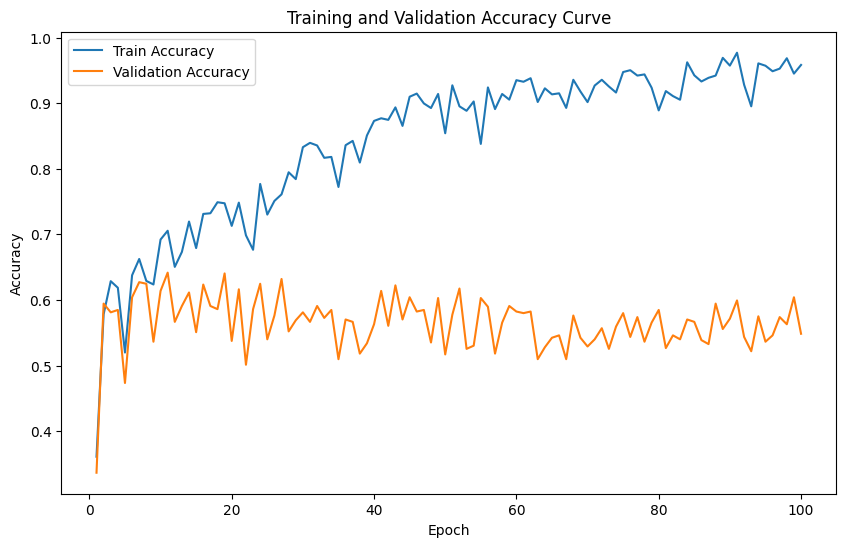

In [17]:
# Step 2: Modify the classifier
num_classes = 5  # Change this to match your number of classes
mobilenet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(576, num_classes),
    nn.LogSoftmax(dim=1)
)

# Step 3: Load and preprocess custom data
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Replace 'path/to/your/dataset' with the actual path to your dataset
train_dataset = datasets.ImageFolder(temp_output_folder, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 4: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Training loop
num_epochs = 100  # Adjust as needed
train_acc_list = []
val_acc_list = []

mobilenet_model.to(device)

for epoch in range(num_epochs):
    mobilenet_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    mobilenet_model.eval()
    with torch.no_grad():
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenet_model(inputs)
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_acc_list.append(train_accuracy)

        correct_val = 0
        total_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenet_model(inputs)
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_acc_list.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plot Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
# Test the model
mobilenet_model.eval()
all_labels = []
all_predictions = []
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    correct_test = 0
    total_test = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet_model(inputs)
        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_test.cpu().numpy())

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



Test Accuracy: 56.66%


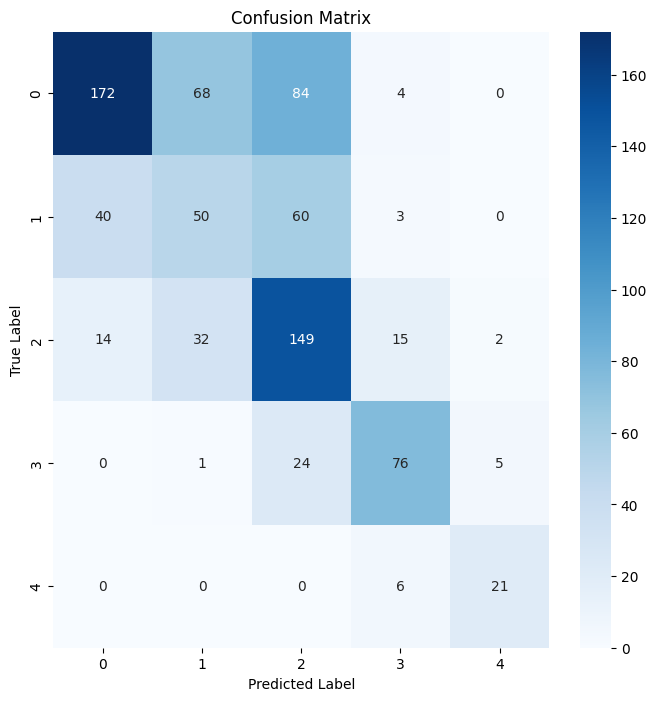

In [19]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [20]:
# import time
# training_start_time = time.time()
# #train your 100 epochs
# print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))